In [1]:
import settings
import helpers

# get data packages
import quandl
import requests

# analysis packages
import pandas as pd
import datetime

import plotly.graph_objs as go
import plotly

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# setting plot sizes to be easier on the eyes
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

In [3]:
quandl.ApiConfig.api_key = settings.get_quandl_api_key()

In [4]:
# date range for data
e_date = datetime.datetime.today()
s_date = e_date - datetime.timedelta(days=365)

In [5]:
df_ust_rates = quandl.get("USTREASURY/YIELD", start_date = s_date, end_date = e_date)

In [6]:
df_ust_rates

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
Date,,,,,,,,,,,,
2019-09-09,2.04,1.99,1.96,1.87,1.74,1.58,1.52,1.49,1.57,1.63,1.91,2.11
2019-09-10,2.04,1.99,1.95,1.89,1.81,1.67,1.61,1.58,1.66,1.72,2.00,2.19
2019-09-11,2.01,1.97,1.96,1.88,1.79,1.68,1.62,1.60,1.68,1.75,2.02,2.22
2019-09-12,1.99,1.97,1.95,1.90,1.82,1.72,1.67,1.65,1.72,1.79,2.06,2.22
2019-09-13,1.99,1.98,1.96,1.92,1.88,1.79,1.76,1.75,1.83,1.90,2.17,2.37
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,0.08,0.10,0.11,0.13,0.12,0.14,0.15,0.28,0.50,0.72,1.26,1.49
2020-09-01,0.09,0.11,0.12,0.13,0.12,0.13,0.14,0.26,0.46,0.68,1.20,1.43
2020-09-02,0.10,0.10,0.12,0.12,0.13,0.14,0.16,0.26,0.45,0.66,1.16,1.38


[Text(0, 0.5, 'Rate'), Text(0.5, 0, 'Tenor')]

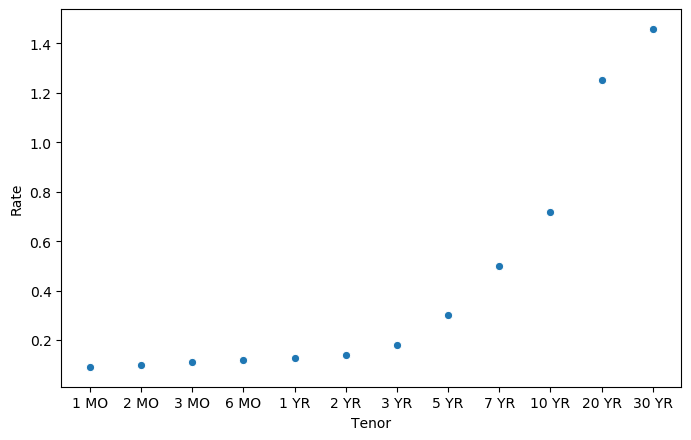

In [7]:
# today's rates
ax = sns.scatterplot(x = 'variable', y = 'value', data = pd.melt(df_ust_rates.tail(1)))
ax.set(xlabel = 'Tenor', ylabel = 'Rate')

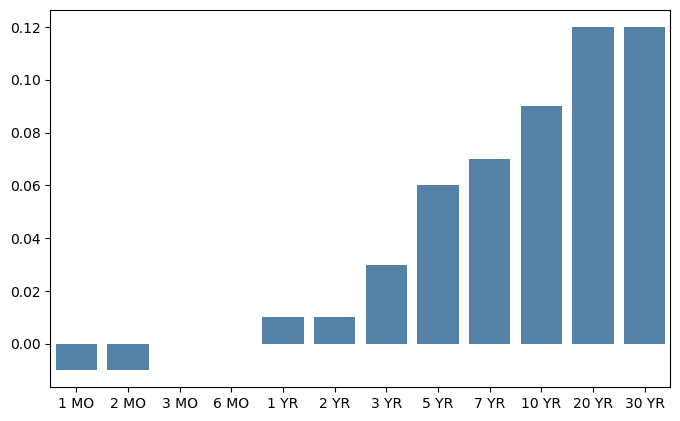

In [8]:
# today's changes
s_daily_change = df_ust_rates.iloc[-1] -  df_ust_rates.iloc[-2]
sns.barplot(s_daily_change.index, s_daily_change.values, color = 'steelblue')

In [9]:
# 2 and 10 spread
df_ust_rates['SPREAD'] = df_ust_rates['10 YR'] - df_ust_rates['2 YR']

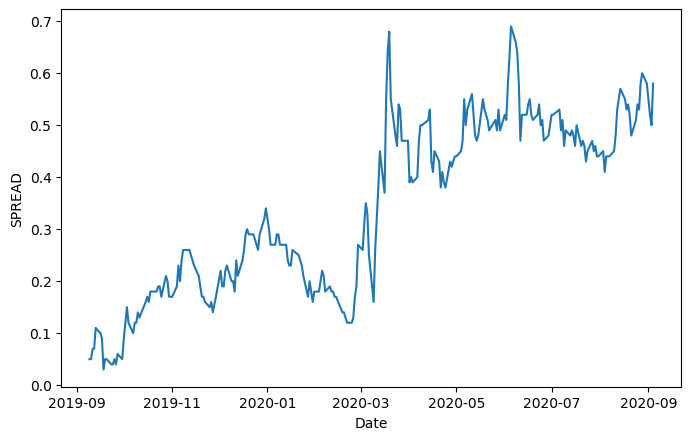

In [10]:
# one year spread
df_ust_rates.reset_index(inplace = True)
sns.lineplot(x = 'Date', y = 'SPREAD', data = df_ust_rates)

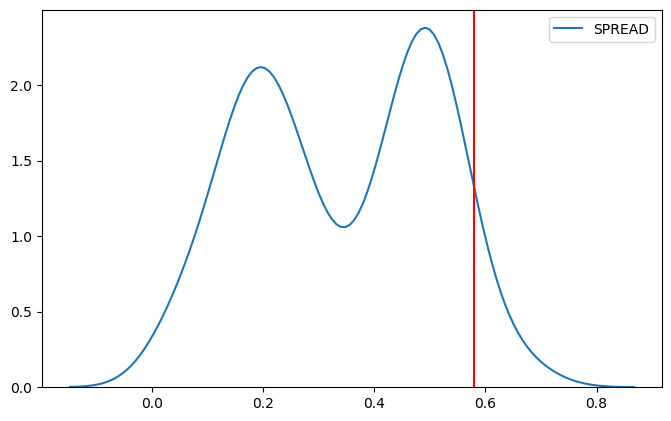

In [11]:
# setting date
ax = sns.kdeplot(df_ust_rates['SPREAD'])
ax.axvline(df_ust_rates.iloc[-1, -1], color='red', label='TODAYLEVEL')

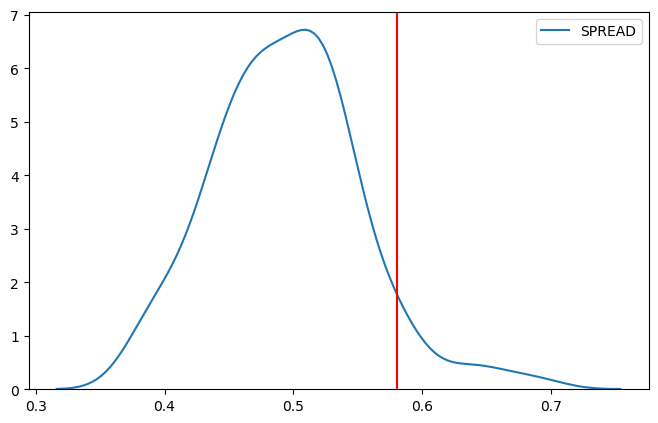

In [12]:
# post fed's rescue package and corporates buying
post_dt = pd.to_datetime('2020-03-23')
ax = sns.kdeplot(df_ust_rates[df_ust_rates['Date'] >= post_dt]['SPREAD'])
ax.axvline(df_ust_rates.iloc[-1, -1], color='red', label='TODAYLEVEL')

In [13]:
# HYG etf holdings
url_hyg_holdings = 'https://www.ishares.com/us/products/239565/ishares-iboxx-high-yield-corporate-bond-etf/1467271812596.ajax?fileType=csv&fileName=HYG_holdings&dataType=fund'
df_hyg = pd.read_csv(url_hyg_holdings, skiprows = 9)

In [14]:
# LQD etf holdings
url_lqd_holdings = 'https://www.ishares.com/us/products/239566/ishares-iboxx-investment-grade-corporate-bond-etf/1467271812596.ajax?fileType=csv&fileName=LQD_holdings&dataType=fund'
df_lqd = pd.read_csv(url_lqd_holdings, skiprows = 9)

In [15]:
d_ishares_sector_mapping = {
    'Communications' : 'Communication Services',
    'Capital Goods' : 'Industrials',
    'Insurance' : 'Financials',
    'Consumer Cyclical' : 'Consumer Discretionary',
    'Brokerage/Asset Managers/Exchanges' : 'Financials',
    'Financial Other' : 'Financials',
    'Finance Companies' : 'Financials',
    'Banking' : 'Financials',
    'Consumer Non-Cyclical' : 'Consumer Staples',
    'Technology' : 'Information Technology',
    'Basic Industry' : 'Materials',
    'Energy' : 'Energy',
    'Reits' : 'Real Estate',
    'Transportation' : 'Industrials',
    'Electric' : 'Energy',
    'Industrial Other' : 'Industrials'
}

# initial processing of HYG and LQD etfs
def format_ishares_bond_etfs(df):

    # formatting the col names
    df.columns = [name if '(%)' not in name else name[:(name.find('(%)') - 1)] for name in df.columns]

    # filtering out unnecessary values
    df = df[df['Asset Class'] == 'Fixed Income']
    df = df[df['YTM'] != '-']
    df = df[df['Sector'] != 'Owned No Guarantee']

    # applying percentages
    l = ['Weight', 'YTM', 'Coupon', 'Real YTM']
    for col in l:
        df[col] = pd.to_numeric(df[col]) / 100
        
    # remapping the sectors to be consistent with SPY ETF
    df['Sector'] = df['Sector'].map(d_ishares_sector_mapping)
    
    # years to maturity
    # df_hyg['Maturity'] = (pd.to_datetime(df_hyg['Maturity']) - e_date) / datetime.timedelta(days = 365)
    return df

In [16]:
df_hyg = format_ishares_bond_etfs(df_hyg)

In [17]:
df_lqd = format_ishares_bond_etfs(df_lqd)

In [18]:
def plot_sector_makeup(df, s_title):
    df_sectors = df[['Sector', 'Weight']].groupby('Sector').sum()
    plt = go.Figure(go.Pie(labels = df_sectors.index, values = df_sectors['Weight'], title = f'{s_title} Sector Makeup'))
    plotly.io.show(plt)

In [19]:
plot_sector_makeup(df_hyg, 'HYG')

In [20]:
plot_sector_makeup(df_lqd, 'LQD')

In [21]:
# weighted real duration
# not using maturity as it's challenging to find embedded optionality data for fixed income products
def get_weighted_real_duration(df):
    weighted_real_duration = (df['Weight'] * df['Real Duration']).sum()
    return f' Weighted Real Duration: {weighted_real_duration}'

# weighted real YTM
def get_weighted_ytm(df):
    weighted_ytm = (df['Weight'] * df['Real YTM']).sum()
    return f' Weighted YTM: {weighted_ytm}'

In [22]:
print('HYG' + get_weighted_real_duration(df_hyg))
print('HYG' + get_weighted_ytm(df_hyg))

HYG Weighted Real Duration: 3.1327840000000005
HYG Weighted YTM: 0.04889731


In [23]:
print('LQD' + get_weighted_real_duration(df_lqd))
print('LQD' + get_weighted_ytm(df_lqd))

LQD Weighted Real Duration: 9.614096
LQD Weighted YTM: 0.02124171


In [24]:
# average YTM by sector
def get_sector_ytm(df):
    return df[['Real YTM', 'Sector']].groupby('Sector').mean()

df_hyg_sector_ytm = get_sector_ytm(df_hyg)
df_lqd_sector_ytm = get_sector_ytm(df_lqd)

In [25]:
fig = {
    'data': [go.Bar(x = df_hyg_sector_ytm.index, y = df_hyg_sector_ytm['Real YTM'], name = 'HYG YTM'),
             go.Bar(x = df_lqd_sector_ytm.index, y = df_lqd_sector_ytm['Real YTM'], name = 'LQD YTM')],
    'layout': go.Layout(barmode='overlay', yaxis=dict(tickformat=".2%"))
}
plotly.io.show(fig)

In [26]:
# relative ytm between LQD and HYG by sector
df_sector_ytm_diff = df_lqd_sector_ytm.div(df_hyg_sector_ytm)
fig = go.Figure(go.Bar(x = df_sector_ytm_diff.index, y = df_sector_ytm_diff['Real YTM']))
plotly.io.show(fig)

In [27]:
# historical spread levels, and how they change DoD

In [28]:
url_holdings_weights = 'https://www.ssga.com/us/en/individual/etfs/library-content/products/fund-data/etfs/us/holdings-daily-us-en-spy.xlsx'
df_sp_constituents = pd.read_excel(url_holdings_weights, usecols = ['Ticker', 'Weight', 'Sector'], skiprows = 4)

In [29]:
df_sp_constituents = df_sp_constituents[~df_sp_constituents['Ticker'].str.contains('CASH', na = True)]

In [30]:
df_sp_constituents['Weight'] = df_sp_constituents['Weight'] / 100

In [31]:
plot_sector_makeup(df_sp_constituents, 'SP500')

In [32]:
tickers = df_sp_constituents['Ticker']

In [33]:
results = helpers.get_eod_equities_data(tickers)

In [34]:
df_sp = pd.DataFrame.from_dict(results, orient = 'index')

In [35]:
df_sp.reset_index(inplace = True)
df_sp.rename(columns = {'index':'Ticker'}, inplace = True)

In [36]:
df_sp = df_sp_constituents.merge(df_sp, on = 'Ticker')

In [37]:
# how much each ticker contribute to the index's move
df_sp['WeightedChangePercent'] = df_sp['Weight'] * df_sp['changePercent']

In [38]:
df_sector_change = df_sp[['Sector', 'WeightedChangePercent']].groupby('Sector').sum()

In [39]:
sectors = df_sector_change.index

In [40]:
plt = go.Figure(go.Bar(x = df_sector_change.index, y = df_sector_change['WeightedChangePercent']))
plt.update_layout(yaxis=dict(tickformat=".2%"))
plotly.io.show(plt)

In [41]:
# average sector volume over 30 day average
df_sp['Over30DVolume'] = df_sp['volume'] / df_sp['avgTotalVolume'] - 1
df_sector_volume = df_sp[['Sector', 'Over30DVolume']].groupby('Sector').mean()

In [49]:
plt = go.Figure(go.Bar(x = df_sector_volume.index, y = df_sector_volume['Over30DVolume']))
plt.update_layout(yaxis=dict(tickformat=".2%"))
plotly.io.show(plt)

In [43]:
# top 10 movers for each sector, bubble size correspond to their size
df_top10_by_sector = df_sp.sort_values(['changePercent', 'Weight'], ascending=False).groupby('Sector').head(10)

In [44]:

d = {}
for sector in sectors:
    df_sector = df_sp[df_sp['Sector'] == sector].sort_values(['changePercent'], ascending = False).head(10)
    d[sector] = df_sector

fig = go.Figure()

for sector, df_sector_top10 in d.items():
    maxval, minval = df_sector_top10['Weight'].max(), df_sector_top10['Weight'].min()
    sizes = [(((weight - minval)/(maxval - minval) + 1) * 100) for weight in df_sector_top10['Weight']]
    fig.add_trace(go.Scatter(
        x = df_sector_top10['Sector'], 
        y = df_sector_top10['changePercent'], 
        text = df_sector_top10['Ticker'],
        name = sector,
        mode = 'markers',
        marker = dict(size = sizes, sizemode = 'area')))

fig.update_layout(yaxis=dict(tickformat=".2%"))    

plotly.io.show(fig)